# GPU Check

In [ ]:
import tensorflow as tf
import time

# Check if a GPU is available
print("Available device:", tf.config.list_physical_devices('GPU'))

# Perform an intensive operation
start = time.time()
a = tf.random.normal([10000, 10000])
b = tf.matmul(a, a)
print("GPU computation time:", time.time() - start)

Dispositivo disponibile: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tempo GPU: 0.8875799179077148


#Import Libraries

In [ ]:
# Install mediapipe library
!pip install mediapipe  # This command installs the mediapipe package, which is used for real-time computer vision tasks.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 45.7 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

In [ ]:
# Import the device_lib module from TensorFlow to check available hardware devices
from tensorflow.python.client import device_lib
# List and print all available devices (CPU, GPU, etc.) on the system
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7030004450490765170
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11012061515905177577
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


#Set the Directory

In [ ]:
# Import the drive module from Google Colab to access Google Drive
from google.colab import drive
# Mount Google Drive to the specified directory in Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys  # Import the sys module to access system-specific parameters and functions
# Add a specific directory to the system path
sys.path.append('/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training')

In [ ]:
# Define the path to the new directory
new_directory = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training'
# Check if the specified directory exists
if os.path.exists(new_directory):
    os.chdir(new_directory) # If the directory exists, change the current working directory to the new directory
    print("Current Directory:", os.getcwd()) # Print the current working directory to confirm the change
else:
    print("Not existing directory:", new_directory) # If the directory does not exist, print a message

Nuova directory di lavoro corrente: /content/drive/Shareddrives/AI - Project/OUR HANDS/tracking training


In [ ]:
# Define the path to the training dataset directory
train_dir = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training/asl_alphabet_train'
# Define the path to the test dataset directory
test_dir = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training/asl_alphabet_test'

#Mediapipe Approach

In [ ]:
from tensorflow.keras.utils import to_categorical  # For one-hot encoding of labels
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets

# Setup MediaPipe for hand tracking
mp_hands = mp.solutions.hands  # Initialize the hand tracking module of MediaPipe
hands = mp_hands.Hands()  # Create an instance of the hand tracking class

# Function to get hand tracking data from images in a directory
def get_hand_tracking_data(data_dir):
    landmarks_list = []  # List to store flattened hand landmark data for each image
    labels = []  # List to store the corresponding labels for each image

    # Ensure consistent order of class directories
    dir_list = sorted(os.listdir(data_dir))  # List all subdirectories (each corresponding to a class)

    # Iterate through each class subdirectory
    for label_idx, class_name in enumerate(dir_list):  # Iterate through each class
        print(f"Obtaining images of class '{class_name}'...")  # Print the current class being processed
        sub_dir = os.path.join(data_dir, class_name)  # Get the path of the class directory

        if os.path.isdir(sub_dir):  # If the directory is valid
            # Iterate through each image in the subdirectory
            for image_name in os.listdir(sub_dir):
                img_path = os.path.join(sub_dir, image_name)  # Get full path of the image
                img = cv2.imread(img_path)  # Read the image

                if img is not None:  # Check if the image was loaded correctly
                    img = cv2.resize(img, (480, 864))  # Resize image to a fixed size (480x864)

                    # Convert image from BGR to RGB (required for MediaPipe processing)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = hands.process(img_rgb)  # Process image to get hand landmarks

                    # If hand landmarks are detected, extract the landmarks
                    if results.multi_hand_landmarks:
                        for landmarks in results.multi_hand_landmarks:  # Iterate through each hand detected
                            # Flatten the landmarks: 21 landmarks, each with 3 coordinates (x, y, z)
                            landmarks_flat = []
                            for landmark in landmarks.landmark:
                                landmarks_flat.append(landmark.x)
                                landmarks_flat.append(landmark.y)
                                landmarks_flat.append(landmark.z)

                            landmarks_list.append(landmarks_flat)  # Append flattened landmarks to the list
                            labels.append(label_idx)  # Append the class label to the labels list

    return np.array(landmarks_list), np.array(labels)  # Return the array of landmarks and labels


# Load training data by calling the function
train_dir = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training/asl_alphabet_train'
X, y = get_hand_tracking_data(train_dir)  # Extract landmarks and labels from the directory
print(f"Loaded {len(X)} images with {len(y)} labels.")  # Print the number of images and labels loaded


# Normalize landmarks (converting to float32 to standardize the data type)
X = X.astype('float32')

# One-hot encode the labels for classification
y = to_categorical(y, num_classes=num_classes)  # Convert labels to one-hot encoded format

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80-20 train-test split

Obtaining images of class 'D'...
Obtaining images of class 'H'...
Obtaining images of class 'K'...
Obtaining images of class 'S'...
Obtaining images of class 'X'...
Loaded 4521 images with 4521 labels.


In [ ]:
# Save the training data (coordinates and labels) to .npy files for future use
np.save('x_train_coordinates.npy', x_train)  # Save the training input data (hand landmarks coordinates)
np.save('y_train_coordinates.npy', y_train)  # Save the training labels (one-hot encoded labels)
np.save('x_test_coordinates.npy', x_test)  # Save the test input data (hand landmarks coordinates)
np.save('y_test_coordinates.npy', y_test)  # Save the test labels (one-hot encoded labels)

In [ ]:
# Load the saved data for further use
x_train = np.load('x_train_coordinates.npy')  # Load the training input data (hand landmarks coordinates)
y_train = np.load('y_train_coordinates.npy')  # Load the training labels (one-hot encoded labels)
x_test = np.load('x_test_coordinates.npy')    # Load the test input data (hand landmarks coordinates)
y_test = np.load('y_test_coordinates.npy')    # Load the test labels (one-hot encoded labels)

# Print the shape of the data to verify
print(f"x_train shape: {x_train.shape}")  # Print the shape of the training input data
print(f"y_train shape: {y_train.shape}")  # Print the shape of the training labels
print(f"x_test shape: {x_test.shape}")    # Print the shape of the test input data
print(f"y_test shape: {y_test.shape}")    # Print the shape of the test labels

# Print the range of pixel values (for verification)
print(f"Pixel range: Min {x_test.min()}, Max {x_test.max()}")  # Check the range of the test input data values

x_train shape: (3616, 63)
y_train shape: (3616, 5)
x_test shape: (905, 63)
y_test shape: (905, 5)
Pixel range: Min -0.5722593665122986, Max 1.0096369981765747


#Model Architecture and Compilation

In [ ]:
# Build a model that accepts landmark data (63 input features - 21 * 3 coordinates)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model configuration parameters
classes = 5  # Total number of classes (signs)
batch_size = 32  # Batch size
epochs = 10  # Number of epochs
learning_rate = 0.005  # Learning rate

# Adam optimizer with specified learning rate
adam = Adam(learning_rate)

# Define the model architecture (adjusted for landmark input)
model = Sequential()  # Start defining a Sequential model

# Input layer (63 input features for the hand landmarks)
# Dense layer with 512 neurons, relu activation, input dimension set to 63 (3 coordinates for 21 landmarks)
model.add(Dense(512, input_dim=63, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer with 30% rate to reduce overfitting

# Hidden layers
# Another Dense layer with 512 neurons, relu activation, followed by Dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer again

# A third Dense layer with 256 neurons, relu activation, followed by Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer again

# Output layer (for 5 classes)
# The output layer has 5 neurons (since we have 5 classes), with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

# Compile the model
# Using Adam optimizer, categorical crossentropy loss function, and accuracy as the metric
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
# Early stopping to halt training when validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce learning rate when validation loss plateaus for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#Model Training

In [ ]:
# Train the model
history = model.fit(
    x_train,  # Training data (landmark coordinates)
    y_train,  # Training labels (one-hot encoded class labels)
    validation_data=(x_test, y_test),  # Validation data to evaluate the model after each epoch
    epochs=epochs,  # Number of epochs for training
    batch_size=batch_size,  # Number of samples per gradient update
    callbacks=[early_stop, reduce_lr]  # Callbacks for early stopping and learning rate reduction
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5506 - loss: 1.0717 - val_accuracy: 0.9746 - val_loss: 0.1245 - learning_rate: 0.0050
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9145 - loss: 0.2717 - val_accuracy: 0.9735 - val_loss: 0.0997 - learning_rate: 0.0050
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9489 - loss: 0.1558 - val_accuracy: 0.9801 - val_loss: 0.1060 - learning_rate: 0.0050
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9370 - loss: 0.1897 - val_accuracy: 0.9702 - val_loss: 0.1282 - learning_rate: 0.0050
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9380 - loss: 0.1685 - val_accuracy: 0.9635 - val_loss: 0.1163 - learning_rate: 0.0050
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9200 - loss: 0.2300 - val_accuracy: 0.9812 - val_loss: 0.0795 - learning_rate: 0.0050
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1501 -

#Model Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0965
Test Accuracy: 0.9845
Test Loss: 0.0710


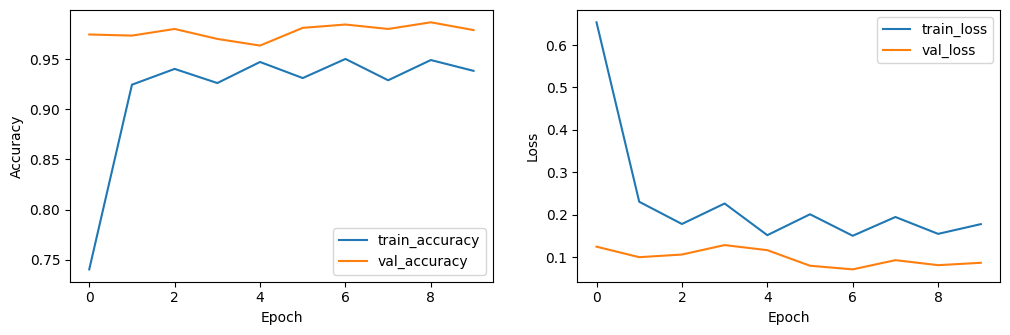

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)  # Evaluate the model on the test data
print(f'Test Accuracy: {test_acc:.4f}')  # Print the test accuracy
print(f'Test Loss: {test_loss:.4f}')  # Print the test loss

# Plot training results
def plot_results():
    # Create a figure with a specific size
    plt.figure(figsize=(12, 12))

    # Plot training and validation accuracy
    plt.subplot(3, 2, 1)  # Create a subplot at position 3x2 grid, 1st position
    plt.plot(history.history['accuracy'], label='train_accuracy')  # Plot train accuracy over epochs
    plt.plot(history.history['val_accuracy'], label='val_accuracy')  # Plot validation accuracy over epochs
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.legend()  # Add legend to the plot

    # Plot training and validation loss
    plt.subplot(3, 2, 2)  # Create a subplot at position 3x2 grid, 2nd position
    plt.plot(history.history['loss'], label='train_loss')  # Plot train loss over epochs
    plt.plot(history.history['val_loss'], label='val_loss')  # Plot validation loss over epochs
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.legend()  # Add legend to the plot

    plt.show()  # Display the plots

# Call the function to plot the training results
plot_results()

# Save the trained model
model.save('asl_model_with_landmarks.keras')  # Save the trained model for future use

In [ ]:
# Print the shape of y_test
print(y_test.shape)  # This prints the shape of the labels (y_test)

# Print the shape of x_test
print("x_test shape:", x_test.shape)  # This prints the shape of the features (x_test)

# Print the model's input shape
print("Model input shape:", model.input_shape)  # This prints the input shape expected by the model

(784, 5)
x_test shape: (784, 128, 128, 3)
Model input shape: (None, 128, 128, 3)


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model from the saved file
model = load_model('asl_model_with_landmarks.keras')

# Model Testing and Tracking Hands Analysis

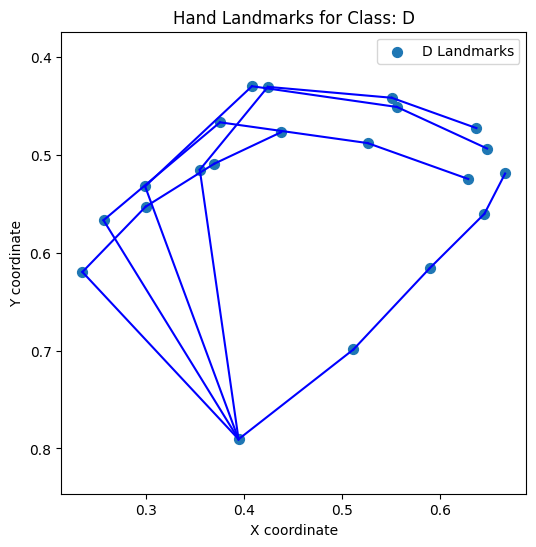

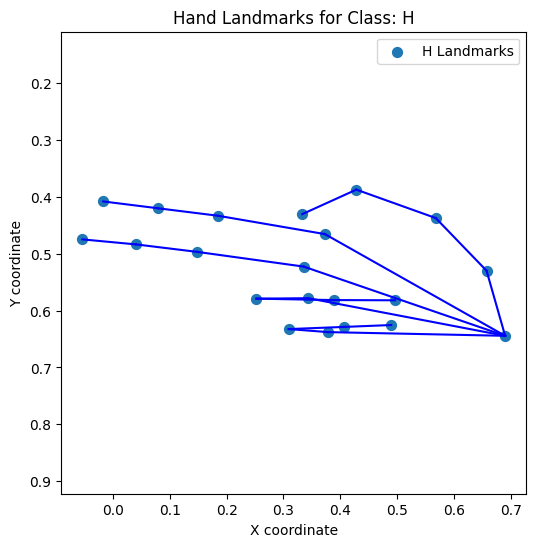

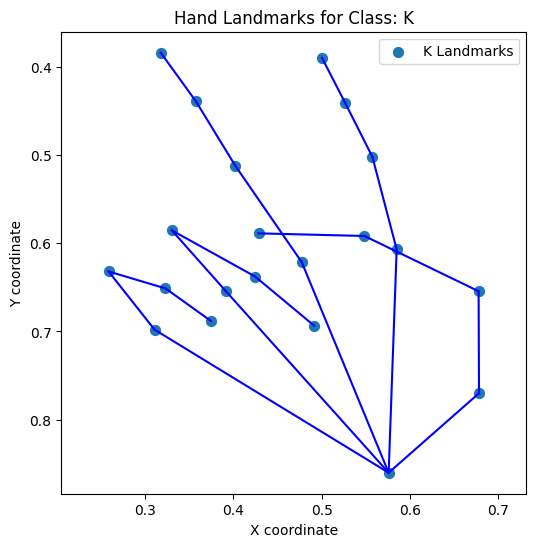

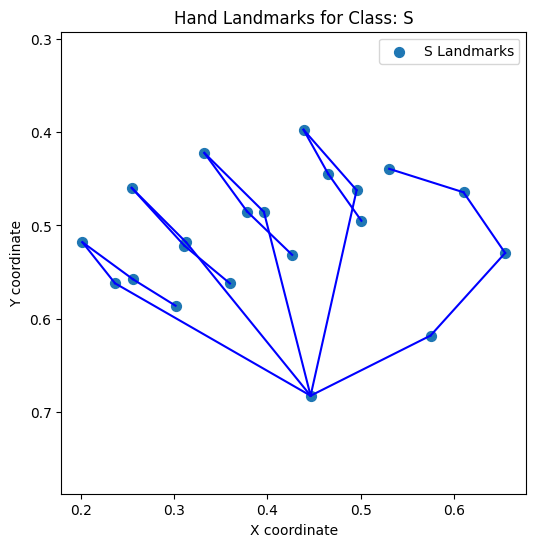

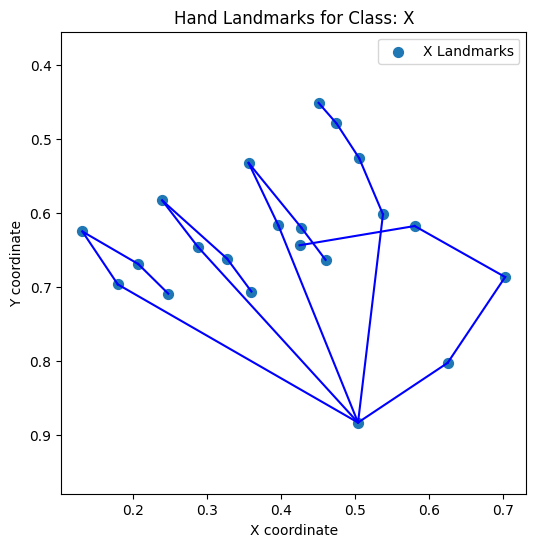

In [ ]:
def plot_hand_landmarks_separate_classes(x_data, y_data, selected_classes, class_names):
    """
    Plots the hand landmarks for multiple classes, each in a separate plot.

    Arguments:
    - x_data: The feature data (hand landmarks)
    - y_data: The label data (one-hot encoded)
    - selected_classes: A list of class labels to visualize
    - class_names: A list of class names corresponding to the labels
    """
    # Loop through the selected classes and create a plot for each class
    for class_name in selected_classes:
        # Find the index of the selected class in class_names
        class_idx = class_names.index(class_name)

        # Create a new figure for each class
        plt.figure(figsize=(6, 6))

        # Loop through the data and find an example with the selected class
        for i in range(len(y_data)):
            if np.argmax(y_data[i]) == class_idx:
                # Reshape the input to extract 21 landmarks, each having 3 coordinates (x, y, z)
                landmarks = x_data[i].reshape((21, 3))

                # Plot the landmarks with a different color for each class
                plt.scatter(landmarks[:, 0], landmarks[:, 1], label=f'{class_name} Landmarks', s=50)

                # Draw lines between connected landmarks (hand skeleton)
                connections = [
                    [0, 1], [1, 2], [2, 3], [3, 4],  # Thumb
                    [0, 5], [5, 6], [6, 7], [7, 8],  # Index finger
                    [0, 9], [9, 10], [10, 11], [11, 12],  # Middle finger
                    [0, 13], [13, 14], [14, 15], [15, 16],  # Ring finger
                    [0, 17], [17, 18], [18, 19], [19, 20]  # Pinky finger
                ]

                # Draw lines between the specified landmarks
                for conn in connections:
                    plt.plot([landmarks[conn[0], 0], landmarks[conn[1], 0]],
                             [landmarks[conn[0], 1], landmarks[conn[1], 1]], 'b-')

                # Stop once a sample for the class is found
                break

        # Add labels and title for each class
        plt.title(f'Hand Landmarks for Class: {class_name}')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.gca().invert_yaxis()  # Invert Y axis to match the image's coordinates
        plt.axis('equal')  # Ensure the aspect ratio is equal for X and Y axes
        plt.legend()  # Add a legend to the plot
        plt.show()  # Display the plot

# Example usage: Visualize landmarks for the classes 'D', 'H', 'K', 'S', 'X'
selected_classes = ['D', 'H', 'K', 'S', 'X']
class_names = ['D', 'H', 'K', 'S', 'X']
plot_hand_landmarks_separate_classes(x_test, y_test, selected_classes, class_names)

#Confusion Matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Accuracy: 98.45%
Correct Predictions: 891
Incorrect Predictions: 14


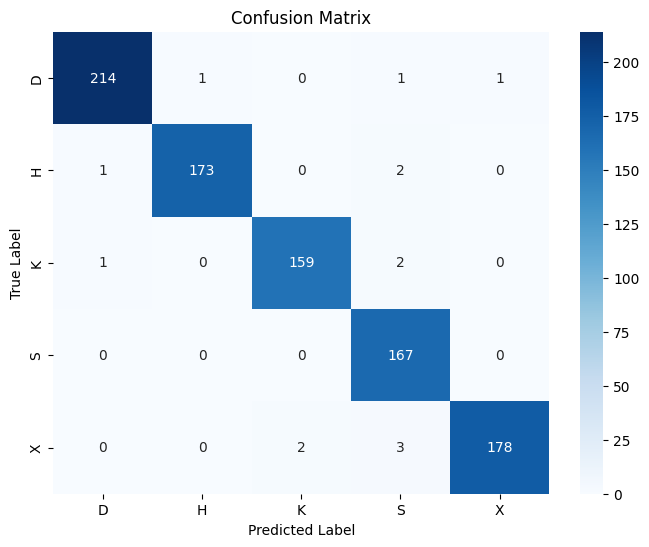

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_model_performance(x_test, y_test, model, class_names):
    """
    Evaluates the performance of a model by calculating accuracy and plotting a confusion matrix.

    Arguments:
    - x_test: Test data (features)
    - y_test: True labels for the test data (one-hot encoded)
    - model: The trained model used for making predictions
    - class_names: List of class names for labeling the confusion matrix
    """

    # Make predictions on the test set using the model
    y_pred = model.predict(x_test)

    # Get the predicted class labels (index of the highest predicted probability)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Get the true class labels (index of the highest true probability)
    y_true_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy: the fraction of correct predictions
    accuracy = np.sum(y_pred_labels == y_true_labels) / len(y_true_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Count correct and incorrect predictions
    correct_predictions = np.sum(y_pred_labels == y_true_labels)
    incorrect_predictions = np.sum(y_pred_labels != y_true_labels)
    print(f'Correct Predictions: {correct_predictions}')
    print(f'Incorrect Predictions: {incorrect_predictions}')

    # Calculate confusion matrix to visualize the performance in terms of true vs predicted labels
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))  # Set the size of the figure
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Set plot title and axis labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display the plot
    plt.show()

# Example usage:
class_names = ['D', 'H', 'K', 'S', 'X']  # Assuming the same class names for hand gestures
evaluate_model_performance(x_test, y_test, model, class_names)

In [ ]:
# Display the summary of the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,284,113 (4.90 MB)

 Trainable params: 428,037 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 856,076 (3.27 MB)

#Evaluation

In [ ]:
import mediapipe as mp
from tensorflow.keras.models import load_model

# Setup MediaPipe for hand tracking
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Function to load 100 random images for each label, extract hand landmarks using MediaPipe,
# and make predictions using a pre-trained model.
def load_and_predict_with_mediapipe(train_dir, model, class_names, num_images=100):
    all_images = []
    all_labels = []

    # Iterate over each class in the dataset
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_dir)

        # Randomly select num_images from the class directory
        selected_files = random.sample(image_files, num_images)

        for image_name in selected_files:
            img_path = os.path.join(class_dir, image_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Convert image to RGB format for MediaPipe processing
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)

                # Check if hand landmarks are detected
                if results.multi_hand_landmarks:
                    # Flatten landmarks (x, y, z coordinates) into a feature vector
                    landmarks = []
                    for landmark in results.multi_hand_landmarks[0].landmark:
                        landmarks.append([landmark.x, landmark.y, landmark.z])  # X, Y, Z coordinates
                    landmarks = np.array(landmarks).flatten()  # Flatten to a single feature vector

                    # Ensure the landmarks shape matches the model input
                    if landmarks.shape[0] == 63:
                        all_images.append(landmarks)
                        all_labels.append(class_idx)

    # Convert lists of images and labels to numpy arrays for predictions
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Normalize the image data (Min-Max normalization)
    all_images = (all_images - np.min(all_images)) / (np.max(all_images) - np.min(all_images))

    # Make predictions using the trained model
    predictions = model.predict(all_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate and print the number of correct and incorrect predictions
    correct = np.sum(predicted_labels == all_labels)
    incorrect = np.sum(predicted_labels != all_labels)

    print(f'Correct predictions: {correct}')
    print(f'Incorrect predictions: {incorrect}')

    # Display some sample predictions (for inspection)
    for i in range(5):  # Show 5 random predictions
        print(f"True label: {class_names[all_labels[i]]}, Predicted: {class_names[predicted_labels[i]]}")

# Example usage:
train_dir = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/tracking training/asl_alphabet_train'
class_names = ['D', 'H', 'K', 'S', 'X']  # Your class names
load_and_predict_with_mediapipe(train_dir, model, class_names)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correct predictions: 345
Incorrect predictions: 148
True label: D, Predicted: S
True label: D, Predicted: S
True label: D, Predicted: S
True label: D, Predicted: D
True label: D, Predicted: S


Image 1: Input shape for prediction: (1, 128, 128, 3)
Image 1:
  Ground Truth: D
  Prediction:   D


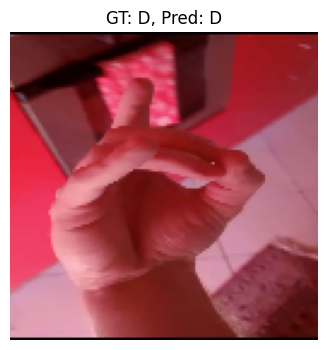

Image 2: Input shape for prediction: (1, 128, 128, 3)
Image 2:
  Ground Truth: K
  Prediction:   K


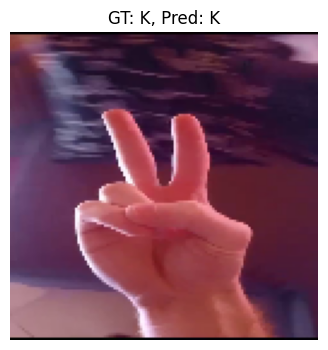

Image 3: Input shape for prediction: (1, 128, 128, 3)
Image 3:
  Ground Truth: X
  Prediction:   X


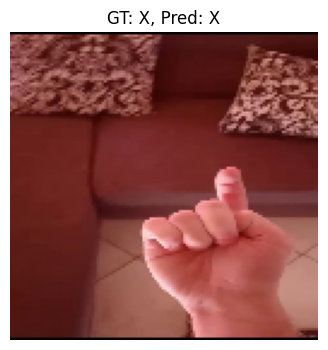

Image 4: Input shape for prediction: (1, 128, 128, 3)
Image 4:
  Ground Truth: K
  Prediction:   K


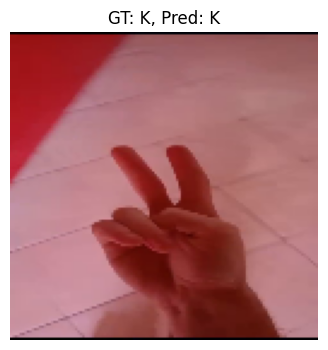

Image 5: Input shape for prediction: (1, 128, 128, 3)
Image 5:
  Ground Truth: K
  Prediction:   K


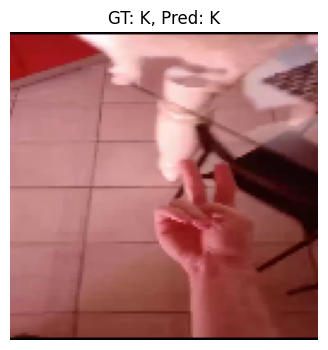

In [ ]:
# Function to predict and visualize predictions on a few test samples
# Decodes the one-hot encoded labels, makes predictions using the trained model,
# and visualizes both the true and predicted labels for a selected set of test images.

def predict_and_visualize(x_test, y_test, model):
    # Decode the one-hot encoded labels
    decoded_labels = np.argmax(y_test, axis=1)

    # Map numeric labels to class names
    class_names = ['D', 'H', 'K', 'S', 'X']

    # Iterate over a few test samples
    for i in range(5):  # Visualize 5 samples (adjust as needed)
        img = x_test[i]  # Extract one image
        true_label = decoded_labels[i]  # True label

        # Ensure the input has the correct shape
        if img.shape != (128, 128, 3):
            print(f"Skipping image {i} due to shape mismatch: {img.shape}")
            continue

        # Add batch dimension
        img_input = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

        # Debugging: Print input shape before prediction
        print(f"Image {i + 1}: Input shape for prediction: {img_input.shape}")

        # Ensure the input is float32 and normalized
        img_input = img_input.astype('float32')  # Ensure correct dtype

        # Predict using the model
        prediction = model.predict(img_input, verbose=0)  # Shape: (1, num_classes)
        predicted_label = np.argmax(prediction)

        # Print predictions and ground truth
        print(f"Image {i + 1}:")
        print(f"  Ground Truth: {class_names[true_label]}")
        print(f"  Prediction:   {class_names[predicted_label]}")

        # Display the image with prediction
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2RGB))  # Convert to displayable format
        plt.title(f"GT: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
        plt.axis('off')
        plt.show()

# Call the prediction and visualization function
predict_and_visualize(x_test, y_test, model)

Image 1:
  Ground Truth: D
  Prediction:   D
No hand landmarks detected in image 1


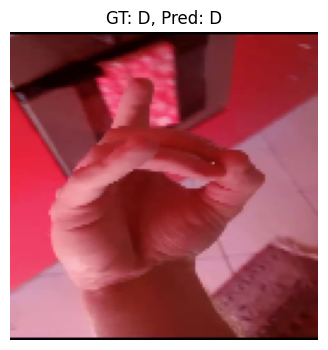

Image 2:
  Ground Truth: K
  Prediction:   D
No hand landmarks detected in image 2


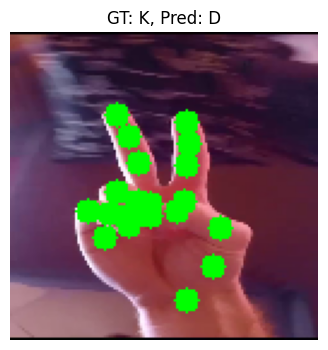

Image 3:
  Ground Truth: X
  Prediction:   D
No hand landmarks detected in image 3


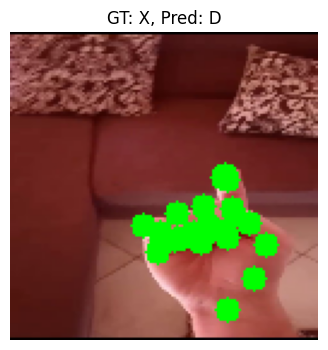

Image 4:
  Ground Truth: K
  Prediction:   D
No hand landmarks detected in image 4


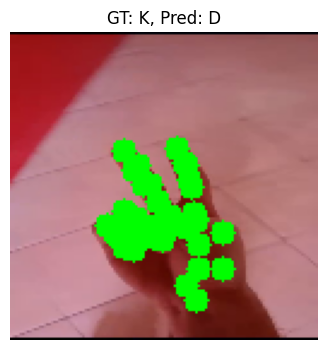

Image 5:
  Ground Truth: K
  Prediction:   S
No hand landmarks detected in image 5


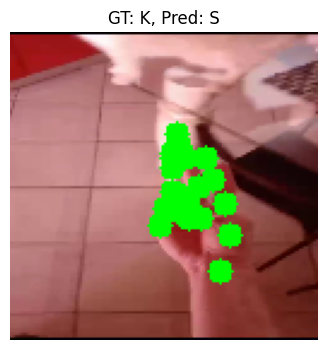

In [ ]:
# Function to predict and visualize the model's predictions on test samples.
# The function also visualizes hand landmarks (if detected) on the test images.

def predict_and_visualize(x_test, y_test, model):
    # Decode the one-hot encoded labels
    decoded_labels = np.argmax(y_test, axis=1)

    # Map numeric labels to class names
    class_names = ['D', 'H', 'K', 'S', 'X']

    # Setup MediaPipe for hand landmarks detection
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    # Iterate over a few test samples (5 samples)
    for i in range(5):  # Visualize 5 samples (adjust as needed)
        img = x_test[i]  # Extract one image
        true_label = decoded_labels[i]  # True label

        # Ensure the input has the correct shape
        if img.shape != (128, 128, 3):
            print(f"Skipping image {i} due to shape mismatch: {img.shape}")
            continue

        # Convert to uint8 as MediaPipe requires uint8 input
        img_uint8 = (img * 255).astype(np.uint8)

        # Convert to RGB as MediaPipe requires RGB input
        img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

        # Process the image to find hand landmarks using MediaPipe
        results = hands.process(img_rgb)

        # Predict using the model (using the original image)
        img_input = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)
        img_input = img_input.astype('float32')  # Ensure correct dtype
        prediction = model.predict(img_input, verbose=0)  # Shape: (1, num_classes)
        predicted_label = np.argmax(prediction)

        # Print predictions and ground truth
        print(f"Image {i + 1}:")
        print(f"  Ground Truth: {class_names[true_label]}")
        print(f"  Prediction:   {class_names[predicted_label]}")

        # Visualize the hand landmarks on the image if available
        if results.multi_hand_landmarks:
            # Loop through the hands detected
            for landmarks in results.multi_hand_landmarks:
                # Draw landmarks on the image
                for landmark in landmarks.landmark:
                    h, w, _ = img.shape
                    cx, cy = int(landmark.x * w), int(landmark.y * h)
                    cv2.circle(img, (cx, cy), 5, (0, 255, 0), -1)  # Draw a circle at each landmark
        else:
            print(f"No hand landmarks detected in image {i + 1}")

        # Display the image with the prediction and landmarks
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to displayable format
        plt.title(f"GT: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
        plt.axis('off')
        plt.show()

# Call the prediction and visualization function
predict_and_visualize(x_test, y_test, model)

#Confusion Matrix

Total Correct Predictions: 739
Total Incorrect Predictions: 45


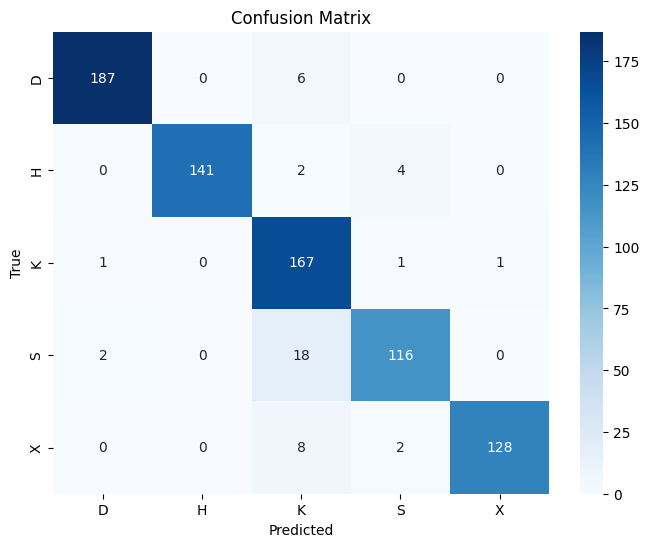

In [ ]:
def predict_and_visualize(x_test, y_test, model):
    # Decode the one-hot encoded labels
    decoded_labels = np.argmax(y_test, axis=1)

    # Map numeric labels to class names
    class_names = ['D', 'H', 'K', 'S', 'X']

    # Initialize counters for correct and incorrect predictions
    correct_predictions = 0
    incorrect_predictions = 0
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Iterate over all test samples
    for i in range(len(x_test)):  # Adjust the range if needed to limit the number of samples
        img = x_test[i]  # Extract one image
        true_label = decoded_labels[i]  # True label

        # Ensure the input has the correct shape
        if img.shape != (128, 128, 3):
            continue  # Skip if image shape doesn't match

        # Add batch dimension
        img_input = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

        # Ensure the input is float32 and normalized
        img_input = img_input.astype('float32')  # Ensure correct dtype

        # Predict using the model
        prediction = model.predict(img_input, verbose=0)  # Shape: (1, num_classes)
        predicted_label = np.argmax(prediction)

        # Update correct/incorrect prediction counts
        if predicted_label == true_label:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

        # Append to true and predicted labels for confusion matrix
        y_true.append(true_label)
        y_pred.append(predicted_label)

    # Calculate and print total correct and incorrect predictions
    print(f"Total Correct Predictions: {correct_predictions}")
    print(f"Total Incorrect Predictions: {incorrect_predictions}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call the prediction and visualization function
predict_and_visualize(x_test, y_test, model)